# optunaでパラメータチューニング
### Objectiveクラスを定義し、独自の引数を持たせてoptuna実行

import os  
gpu_num = "2,3"  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

In [1]:
# モジュールimport
import os, sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
path = os.path.join(current_dir, '../')
sys.path.append(path)
from dataset import plot_log, prepare_data, util, plot_12task_log
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric
from tuning import optuna_train_base, optuna_train_Tox21
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict, base_predict

import keras
import keras.backend as K
import matplotlib.pyplot as plt

#sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
#from random_eraser import get_random_eraser

#sys.path.append(r'/home/aaa00162/jupyterhub/notebook/other/lib_DL/optuna-master')
import optuna
import numpy as np
import shutil
%matplotlib inline

%reload_ext autoreload
%autoreload 2

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


Using TensorFlow backend.


my_generator.py: loaded as module file
get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
optuna_train_base.py: loaded as module file
optuna_train.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file
base_predict.py: loaded as module file


### 固定パラメータ
- バッチサイズ
- 出力ディレクトリ
- 画像サイズ: 100x100
- クラス数：5
- エポック数
- GPUの数
- 損失関数
- metrics
- 出力層の活性化関数: sigmoid（マルチラベルなので）
- 出力層の重みの初期値: zeros
- 出力層のl2: 1e-4
- FCのpooling方法: GlobalAveragePooling2D
- callback
    - keras.callbacks.TerminateOnNaN: lossがNaNになった時に訓練を終了する
    - #keras.callbacks.ModelCheckpoint: val_loss最少になるモデルを保存する
    - #keras.callbacks.EarlyStopping: val_lossが100エポック更新されなければ学習停止する
    - cosine_annealing: lr*0.01
    - keras.callbacks.CSVLogger: 各エポックの結果をcsvファイルに保存する
    - my_callback.tsv_logger: 各エポックの結果をtsvファイルに保存する

In [2]:
# batch_size
train_batch_size=100
valid_batch_size=100

# 出力ディレクトリ
out_dir = 'output_test_optuna/100x100'
os.makedirs(out_dir, exist_ok=True)

# 入力層のサイズ
shape=[100, 100, 3]

# クラス数
num_classes=5

# エポック数
epochs=2

# GPUの数
gpu_num = '0'
gpu_count=len(gpu_num.split(','))
print('gpu_count:', gpu_count)

# 損失関数
loss = multi_loss.build_masked_loss(K.binary_crossentropy) 

# metrics
metrics = ['acc', 'binary_accuracy', multi_loss.masked_accuracy]

# 出力層の活性化関数
activation = 'sigmoid'
pred_kernel_initializer='zeros'
pred_l2_rate=1e-4

# pooling方法
FCpool='GlobalAveragePooling2D'

# callback
cb_base = []
if gpu_count > 1:
    # batch_sizeは並列で処理を行うために元々のbatch_sizeをGPUの数だけ掛ける
    train_batch_size = train_batch_size * gpu_count
    valid_batch_size = valid_batch_size * gpu_count
else:
    cb_base.append(keras.callbacks.TerminateOnNaN())
    # keras.callbacks.EarlyStopping
    early_monitor='val_loss' # val_lossが100エポック更新されなければ学習停止する
    early_stopping_pati=10
    cb_base.append(keras.callbacks.EarlyStopping(monitor=early_monitor, patience=early_stopping_pati, verbose=1))
    
# 学習率をエポック増やすごとにコサインカーブのように上げ下げする
## 引数なしならlr*0.01まで下げるだけ
#cb_base.append(my_callback.cosine_annealing())

cb_base.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history.tsv'), separator='\t'))
cb_base.append(my_callback.tsv_logger(os.path.join(out_dir, 'tsv_logger.tsv')))
print(cb_base)

gpu_count: 1
[<keras.callbacks.TerminateOnNaN object at 0x00000266D8F19518>, <keras.callbacks.EarlyStopping object at 0x00000266D8F194E0>, <keras.callbacks.CSVLogger object at 0x00000266D341E550>, <model.my_callback.tsv_logger.<locals>._TSVLogger object at 0x00000266D8F195C0>]


## マルチラベルサンプルデータ
- https://blog.manash.me/multi-task-learning-in-keras-implementation-of-multi-task-classification-loss-f1d42da5c3f6
- classes = np.array(['desert', 'mountain', 'sea', 'sunset', 'trees'])

C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning:

dataset.value has been deprecated. Use dataset[()] instead.



(1600, 100, 100, 3)
(400, 100, 100, 3)


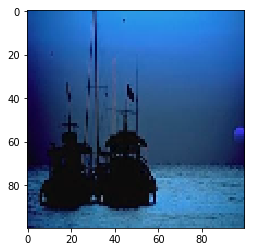

In [3]:
# Downloading and Viewing the dataset

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#Jupyterでインライン表示するための宣言
%matplotlib inline

def load():
    f = h5py.File("01_code_test/dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load()
plt.imshow(x_train[0])
print(x_train.shape)
print(x_test.shape)

### データ管理クラス定義
- d_cls.train_gen: train set のImageDataGenerator
- d_cls.valid_gen: validation set のImageDataGenerator

In [4]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import sys
# /home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator
#sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser

### Dataset management class
class LabeledDataset:
    """
    データ管理用クラス
    cpuのメモリに全画像データを持つのでcpuのメモリ少ない場合は使えないかも
    """
    def __init__(self, shape, train_batch_size, valid_batch_size, X_train, y_train, X_valid, y_valid):
        self.shape = shape
        self.train_batch_size = train_batch_size
        self.valid_batch_size = valid_batch_size
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
    
    def create_generator(self, use_mixup=False, IDG_options={}):
        """trainとvalidationのImageDataGenerator作成"""
        print('----- train_ImageDataGenerator -----')
        print('use_mixup:', use_mixup)
        print('IDG_options:', IDG_options)
        aug_datagen = ImageDataGenerator(**IDG_options)
        if use_mixup:
            # ラベルに-1が混じってるからMixup使うと、ラベルも混ぜるのでlossがマイナスになる
            # 今回はMixupつかえない
            self.train_gen = MixupGenerator(self.X_train, self.y_train, alpha=1.0, batch_size=self.train_batch_size, datagen=aug_datagen)()
        else:
            self.train_gen = aug_datagen.flow(self.X_train, self.y_train, batch_size=self.train_batch_size)
        plain_datagen = ImageDataGenerator()
        self.valid_gen = plain_datagen.flow(self.X_valid, self.y_valid, batch_size=self.valid_batch_size, shuffle=False)
        return self.train_gen, self.valid_gen
    
    def train_steps_per_epoch(self):
        """fit_generatorで指定するtrainのsteps_per_epoch"""
        return len(self.X_train) // self.train_batch_size
    
    def valid_steps_per_epoch(self):
        """fit_generatorで指定するvalidationのsteps_per_epoch"""
        return len(self.X_valid) // self.valid_batch_size
    
d_cls = LabeledDataset(shape, train_batch_size, valid_batch_size, x_train, y_train, x_test, y_test)

### 目的関数の定義
#### チューニング可能パラメータ
- モデル（ニューラルネットワーク）
    - Imagenetの学習済みモデル
    - fine-tuning
    - 全結合0-5層（重みの初期値はhe_normal(He の正規分布)で固定）
        - ユニット数 (同じ値か層ごとに減らす)
        - dropout_rate (全層同じ値になる)
        - Batch_Normalization (全層同じ値になる)
        - l2正則化(weight decay) (全層同じ値になる)
- オプティマイザ
- 学習率
    - 学習率変更なし
    - cosine_annealing(factor=0.01, epochs=None)
    - LearningRateScheduler(lr* 1/4 を3回する)
- データ水増し( keras.preprocessing.image.ImageDataGenerator )
    - 画像の剪断(shear)
    - 拡大縮小(zoom)
    - 回転(rotation)
    - 上下反転(vertical_flip)
    - 左右反転(horizontal_flip)
    - 画像の一部矩形領域を隠す（random_erasing)
    - 画像混ぜる(mix_up)

In [8]:
## best_parameter をval_loss でとる
return_val_loss=True

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['EfficientNet']#['SEInceptionV3']# 学習済みモデル
efficientnet_num = [0,1,2,3]
trainable = ['all'] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
FCnum = [0,1,4] # FC層の数
Dence = [1024, 512, 256, 128] # FC層のユニット数
Dropout = [0.0, 0.5] # FC層のDropout
addBatchNorm = [None] # FC層のBatchNorm
l2 = [0.0, 1e-4] # FC層のl2
choice_optim = ['sgd', 'adam', 'nadam'] # optimizer
lr = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # （初期）学習率
callback_lr = [None, 'cosine_annealing'] # 学習率変更するcallback
callback_save_model=False#True # 全モデル保存するcallback つけるか. False なら保存しない

if callback_save_model == True:
    model_dir = os.path.join(out_dir, 'model_weight_optuna')

## ImageDataGenerator param
horizontal_flip=[True] # 画像の左右反転
vertical_flip=[True] # 画像の上下反転
# 画像の回転の下限角、回転の上限角、回転角の刻み幅
rotation_range_min=60 
rotation_range_max=60
rotation_unit=0.0 # 0.0 にしたら rotation_range_max で固定
# 画像の縮小の最少-最大倍率、拡大の最少-最大倍率、縮小拡大倍率の刻み幅
zoom_range_low_min=0.5
zoom_range_low_max=0.5
zoom_range_high_min=1.9
zoom_range_high_max=1.9
zoom_range_unit=0.0 # 0.0 にしたら zoom_range_low_min, zoom_range_high_max で固定
# 画像のせん断の最少倍率、せん断の最大倍率、せん断倍率の刻み幅
shear_range_min=0.2
shear_range_max=0.2
shear_range_unit=0.0 # 0.0 にしたら shear_range_max で固定
random_eraser_flg= [True] # Random Erasing 含めるか
pixel_min=np.min(d_cls.X_train) # Random Erasing で使う画素数の最小値
pixel_max=np.max(d_cls.X_train) # Random Erasing で使う画像数の最大値（1/255で割ってるはずだから基本1.0）
use_mixup=[False] # mixup 含めるか

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train_Tox21.Objective(out_dir, d_cls
                                   , shape=shape
                                   , num_classes=num_classes
                                   , epochs=epochs
                                   , gpu_count=gpu_count
                                   , loss=loss
                                   , metrics=metrics
                                   , verbose=0
                                   , activation=activation
                                   , pred_kernel_initializer=pred_kernel_initializer
                                   , pred_l2_rate=pred_l2_rate
                                   , FCpool=FCpool
                                   , return_val_loss=return_val_loss
                                   , callbacks=cb_base
                                   , callback_save_model=callback_save_model
                                   , choice_model=choice_model
                                   , trainable=trainable
                                   , FCnum=FCnum
                                   , Dence=Dence
                                   , Dropout=Dropout
                                   , addBatchNorm=addBatchNorm
                                   , l2=l2
                                   , efficientnet_num=efficientnet_num
                                   , choice_optim=choice_optim
                                   , lr=lr
                                   , callback_lr=callback_lr
                                   , horizontal_flip=horizontal_flip
                                   , vertical_flip=vertical_flip
                                   , rotation_range_min=rotation_range_min
                                   , rotation_range_max=rotation_range_max
                                   , rotation_unit=rotation_unit
                                   , zoom_range_low_min=zoom_range_low_min
                                   , zoom_range_low_max=zoom_range_low_max
                                   , zoom_range_high_min=zoom_range_high_min
                                   , zoom_range_high_max=zoom_range_high_max
                                   , zoom_range_unit=zoom_range_unit
                                   , shear_range_min=shear_range_min
                                   , shear_range_max=shear_range_max
                                   , shear_range_unit=shear_range_unit
                                   , random_eraser_flg=random_eraser_flg
                                   , pixel_min=pixel_min
                                   , pixel_max=pixel_max
                                   , use_mixup=use_mixup
                                   , branch_Tox21_12task=[False]
                                  )

### 最適化の実行

In [ ]:
%%time
# sqlite 使って履歴ファイル作る
sqllite_path = out_dir+'/example.db'
#if os.path.exists(sqllite_path) == True:
#    os.remove(sqllite_path) # sqllite_pathすでにあれば一旦削除
study = optuna.create_study(study_name='example-study'
                            , storage='sqlite:///'+sqllite_path
                            , load_if_exists=True # すでに DB が存在していた場合はそのデータを読み込んで、最適化を再開
                           )

study.optimize(objective, n_trials=3)

### 結果の確認

In [7]:
# 試行結果データフレームで出力
study = optuna.Study(study_name='example-study', storage='sqlite:///'+sqllite_path)
df = study.trials_dataframe()
df.to_csv(os.path.join(out_dir, 'optuna_lgb.tsv'), sep='\t')
df

number                state     value             datetime_start  \
                                                                     
0      0  TrialState.COMPLETE  0.593420 2019-06-18 23:59:18.824426   
1      1  TrialState.COMPLETE  0.562609 2019-06-19 00:00:53.661853   
2      2  TrialState.COMPLETE  0.712497 2019-06-19 00:01:33.629843   

           datetime_complete  params                                  ...  \
                             Dence_1 Dence_2 Dence_3 Dence_4 Dropout  ...   
0 2019-06-19 00:00:53.636185     512   384.0   192.0   144.0     0.5  ...   
1 2019-06-19 00:01:33.598590     256     NaN     NaN     NaN     0.0  ...   
2 2019-06-19 00:02:22.687012     128     NaN     NaN     NaN     0.5  ...   

    user_attrs                                                              \
  pred_l2_rate rotation_range          shape shear_range val_acc  val_loss   
0       0.0001             60  [100, 100, 3]         0.2    0.76  0.593420   
1       0.0001             60  [100, 100, 3]         0.2    0.76  0.562609   
2       0.0001             60  [100, 100, 3]         0.2    0.76  0.712497   

                 system_attrs intermediate_values            
  zoom_range_low      _number                   0         1  
0            0.5            0            0.594848  0.593420  
1            0.5            1            0.601892  0.562609  
2            0.5            2            0.712507  0.712497  

[3 rows x 44 columns]

In [8]:
# study.best_params ファイル出力
f = open(os.path.join(out_dir, 'best_params.txt'), 'w') # 書き込みモードで開く
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
study.best_params

{'Dence_1': 1024,
 'Dropout': 0.5,
 'FCnum': 1,
 'addBatchNorm': None,
 'branch_Tox21_12task': False,
 'callback_lr': None,
 'choice_model': 'SEInceptionV3',
 'choice_optim': 'sgd',
 'horizontal_flip': True,
 'l2': 0.0001,
 'lr': 0.001,
 'random_eraser_flg': True,
 'trainable': 'all',
 'use_mixup': False,
 'vertical_flip': True}

In [9]:
study.best_trial 

FrozenTrial(number=0, state=<TrialState.COMPLETE: 1>, value=0.8770063817501068, datetime_start=datetime.datetime(2019, 3, 14, 19, 53, 55, 195951), datetime_complete=datetime.datetime(2019, 3, 14, 19, 54, 58, 379085), params={'Dence_1': 1024, 'Dropout': 0.5, 'FCnum': 1, 'addBatchNorm': None, 'branch_Tox21_12task': False, 'callback_lr': None, 'choice_model': 'SEInceptionV3', 'choice_optim': 'sgd', 'horizontal_flip': True, 'l2': 0.0001, 'lr': 0.001, 'random_eraser_flg': True, 'trainable': 'all', 'use_mixup': False, 'vertical_flip': True}, user_attrs={'FCpool': 'GlobalAveragePooling2D', 'acc': 0.8181249988265336, 'activation': 'sigmoid', 'callbacks': '[<keras.callbacks.TerminateOnNaN object at 0x000002B19854A6A0>, <keras.callbacks.EarlyStopping object at 0x000002B19854A780>, <keras.callbacks.CSVLogger object at 0x000002B189D72550>, <model.my_callback.tsv_logger.<locals>._TSVLogger object at 0x000002B19854A7B8>]', 'gpu_count': '1', 'loss': 0.8078281097114086, 'metrics': "['acc', 'binary_acc

In [10]:
# optunw v 0.7.0
from optuna.visualization import plot_intermediate_values
plot_intermediate_values(study)

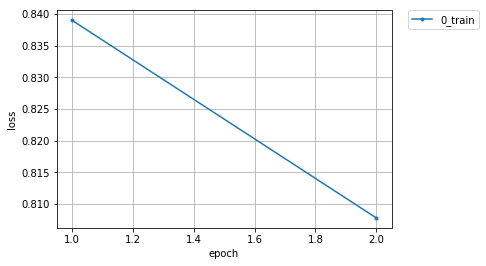

<Figure size 432x288 with 0 Axes>

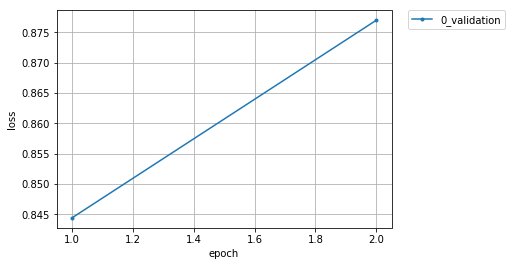

<Figure size 432x288 with 0 Axes>

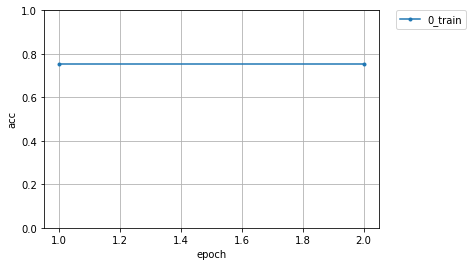

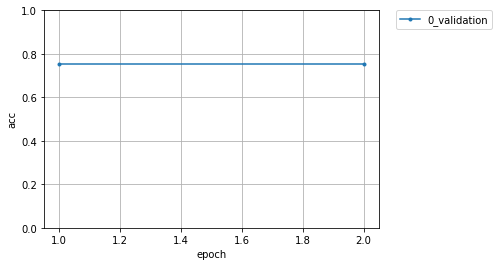

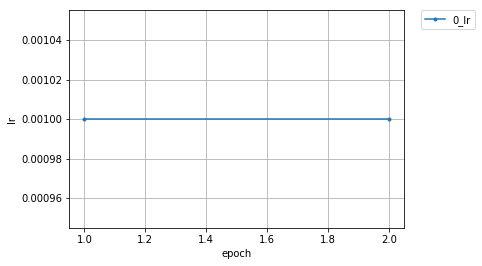

<Figure size 432x288 with 0 Axes>

In [12]:
import glob
hist_file_list = glob.glob(out_dir+'/tsv_logger/*.tsv')
plot_log.overlaid_plot_results(out_dir, hist_file_list)